In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ursse.phase_space_trajectory as pst
# import ursse_cpp.sync_motion_sim as sm
from config_ursse import get_from_config, get_path_from_config, save_to_config
from ursse.path_assistant import PathAssistant
import os
import valstore as vt
images_dir = os.path.join(get_path_from_config("URSSE_sync_motion_note_dir"),
                          "images")
shift = PathAssistant('shift_05_28_2021')
np_rand_seed = 1
from ursse.data_processing import \
    get_event_delays, plot_arrival_time_hist, get_events_array, get_fanos, \
    plot_fanos_hist, process_file, read_event_delays, save_event_delays

iota_period_sec = get_from_config("IOTA_revolution_period")
dt_sec = get_from_config("dt")
iota_period_au = iota_period_sec/dt_sec

In [2]:
file_name = '1el_000.ptu'
df = pd.read_pickle(shift.get_pickle_path(file_name))
df

,revolution,channel,delay
0,388,3,59547
1,399,2,20291
2,491,2,20153
3,917,2,20301
4,1013,2,20417
...,...,...,...
7080715,1226944208,3,28329
7080716,1226961325,3,74516
7080717,1226964318,3,31166
7080718,1227006345,3,17320


In [21]:
dt = 10 # sec
n_per = dt/iota_period_sec
rev = df['revolution']
grouped = rev.groupby((rev/n_per).astype(int))
av_rate = grouped.apply(lambda x: len(x.index))
av_rev = grouped.apply(np.mean) calendar
av_rate0 = av_rate[0]
av_rev[av_rate > av_rate0/2][:-1].iloc[-1]

1012517477.5220133

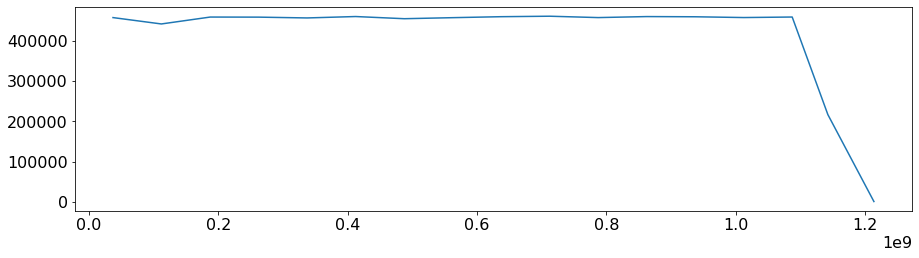

In [28]:
plt.plot(av_rev, av_rate)

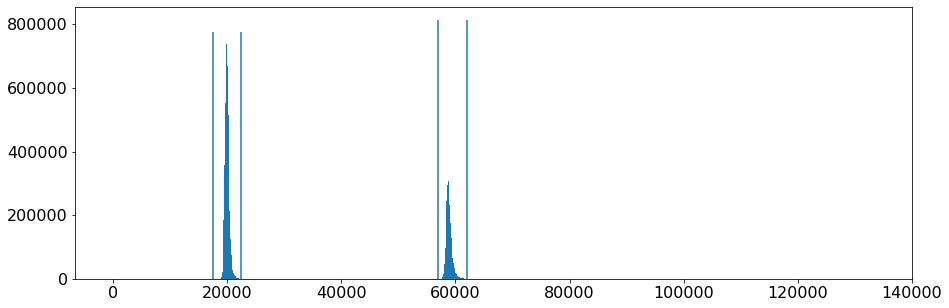

In [22]:
spad1_channel = 2
spad2_channel = 3
fig, ax = plt.subplots(figsize=(15,5))
ax.hist(df['delay'], bins=1000)
gate1 = (17500,22500)
ax.vlines(gate1, *ax.get_ylim())
gate2 = (57000, 62000)
ax.vlines(gate2, *ax.get_ylim())
plt.show()

In [23]:
df1_ = df[df['delay'].between(*gate1)].reset_index(drop=True)
np.sum(df1_['channel'] == spad1_channel), np.sum(df1_['channel'] == spad2_channel)

(4692357, 641)

In [24]:
df2_ = df[df['delay'].between(*gate2)].reset_index(drop=True)
np.sum(df2_['channel'] == spad2_channel), np.sum(df2_['channel'] == spad1_channel)

(2343620, 979)

In [25]:
df1 = df1_[df1_['channel'] == spad1_channel].drop(columns=['channel'])
df2 = df2_[df2_['channel'] == spad2_channel].drop(columns=['channel'])

In [26]:
total_iota_revolutions = df.iloc[-1]['revolution']
total_time = total_iota_revolutions * iota_period_sec
total_time

163.60115666666667

In [27]:
total_iota_revolutions

1227008675

In [8]:
spad1_events = len(df1.index)
spad1_events/total_time

28681.685970965118

In [9]:
spad2_events = len(df2.index)
spad2_events/total_time

14325.204342992929

In [10]:
print("Std of arrival times in gate1 and gate2 (ps):")
df1['delay'].std(), df2['delay'].std()

Std of arrival times in gate1 and gate2 (ps):


(370.43728009510966, 496.8633081458801)

In [11]:
np.sum(df1['revolution'].value_counts() > 1), np.sum(df2['revolution'].value_counts() > 1)

(0, 0)

In [12]:
clean_df = df[(df['delay'].between(*gate1) & (df['channel'] == spad1_channel))\
              | (df['delay'].between(*gate2) & (df['channel'] == spad2_channel))]

In [13]:
coincidence_events = np.sum(clean_df['revolution'].value_counts() == 2)
coincidence_events/total_time

57.82355206249866

In [14]:
p1 = spad1_events/total_iota_revolutions
p2 = spad2_events/total_iota_revolutions
p12_meas = coincidence_events/total_iota_revolutions
p12_meas, p1*p2

(7.709806941666489e-06, 7.304373554411181e-06)

In [2]:
def load_one_pickle(pickle_path, gate1=(17500, 22500), gate2=(57000, 62000), spad1_channel=2, spad2_channel=3):
    df = pd.read_pickle(pickle_path)
    total_iota_revolutions = df.iloc[-1]['revolution']
    df1_ = df[df['delay'].between(*gate1)].reset_index(drop=True)
    df2_ = df[df['delay'].between(*gate2)].reset_index(drop=True)
    df1 = df1_[df1_['channel'] == spad1_channel].drop(columns=['channel'])
    df2 = df2_[df2_['channel'] == spad2_channel].drop(columns=['channel'])
    total_iota_revolutions = df.iloc[-1]['revolution']
    total_time = total_iota_revolutions * iota_period_sec
    spad1_events = len(df1.index)
    rate1 = spad1_events/total_time
    spad2_events = len(df2.index)
    rate2 = spad2_events/total_time
    num_rev_above_one1 = np.sum(df1['revolution'].value_counts() > 1)
    num_rev_above_one2 = np.sum(df2['revolution'].value_counts() > 1)
    clean_df = df[(df['delay'].between(*gate1) & (df['channel'] == spad1_channel))\
              | (df['delay'].between(*gate2) & (df['channel'] == spad2_channel))]
    coincidence_events = np.sum(clean_df['revolution'].value_counts() == 2)
    coincidence_count_rate = coincidence_events/total_time
    p1 = spad1_events/total_iota_revolutions
    p2 = spad2_events/total_iota_revolutions
    p12_meas = coincidence_events/total_iota_revolutions
    return {
        "df": [df1, df2],
        "clean_df": clean_df,
        "total_iota_revolutions": total_iota_revolutions,
        "total_time": total_time,
        "total_events": [spad1_events, spad2_events],
        "count_rate": [rate1, rate2],
        "num_rev_above_one": [num_rev_above_one1, num_rev_above_one2],
        "coincidence_count_rate": coincidence_count_rate,
        "p": [p1, p2],
        "p12_meas": p12_meas,
        "p1*p2": p1*p2
    }

In [4]:
res_dic = load_one_pickle(shift.get_pickle_path('1el_000.ptu'))

In [5]:
res_dic['df'][0]

,revolution,delay
0,399,20291
1,491,20153
2,917,20301
3,1013,20417
4,1068,20120
...,...,...
4692984,1214647914,20345
4692985,1215672543,17648
4692988,1218067360,20532
4692990,1220727510,20814


In [6]:
res_dic.keys()

dict_keys(['df', 'clean_df', 'total_iota_revolutions', 'total_time', 'total_events', 'count_rate', 'num_rev_above_one', 'coincidence_count_rate', 'p', 'p12_meas', 'p1*p2'])

In [7]:
res_dic['count_rate']

[28681.685970965118, 14325.204342992929]